In [8]:
# importing necassery packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib inline` is a magic command in Jupyter notebooks that allows plots to be displayed directly within the notebook. 
pd.options.display.float_format = '{:,.2f}'.format  # Set to two decimal places, for example

%matplotlib inline
import matplotlib
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams["figure.figsize"] = (20,10)

## Data Cleaning
Remove rows with missing values and understanding dataset.There are some data that are ambiguous like room with 42 bedrooms whihc are ambiguous and needs to be removed.

In [9]:
df=pd.read_csv("Bengaluru_House_Data.csv")
print(df.columns)

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')


In [10]:
#removing unwanted features
df1=df.drop(['area_type','availability','society','balcony'],axis='columns') # new dataframe after removing unwanted features
df1.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.00,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.00,120.00
2,Uttarahalli,3 BHK,1440,2.00,62.00
3,Lingadheeranahalli,3 BHK,1521,3.00,95.00
4,Kothanur,2 BHK,1200,2.00,51.00


In [11]:
# data cleaning by removing row with NaN (Not A Number)
#df1.isnull().sum() to count the number of missing values in each column
# print(df1.isnull().sum())

# defined to extract the numerical value from the 'size' column
def changeToNumber(row):
    return int(row['size'].split(' ')[0])
# removing rows with NaN vallue
df1=df1.dropna(axis=0)
df1.head()
df1['size'].unique()
df1['bhk']=df1.apply(changeToNumber,axis=1)
# print(sorted(df1['bhk'].unique()))
# df1[df1.bhk > 9]['bhk'].count() 
# df1=df1[df1.bhk <9] # removing column where bhk>9 

In [12]:
# total_sqft have values in string format and some values are given in range 
# so remove the data which are corrupted
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True
df1[~df1['total_sqft'].apply(is_float)].shape
#there are 186 record with total_sqft that cannot be converted we need to convert those to float

def convert_total_sqft(col):
    values=col.split("-")
    if len(values)==2:
        return (float(values[0])+float(values[1]))/2
    try:
        return float(col)
    except:
        return None
df2=df1.copy()
df2['total_sqft'] = df2['total_sqft'].apply(convert_total_sqft)
df2=df2.dropna(axis=0)

## Feature Engineering And Dimensional Reduction

In [13]:
# creating new feature price per square feet
df2['price_per_sqft']=df2['price']*100000/df2['total_sqft']
df2.head()

df2.location=df2.location.apply(lambda x:x.strip())
location_stats=df2.groupby('location')['location'].agg('count').sort_values(ascending=False)
print(len(location_stats))#1287 unique locations and some will only have two or one data point
print(len(location_stats[location_stats<=10])) #1047 rown with unique values less than 10 data points

location_unique=location_stats[location_stats<=10]
def change_to_other(col):
    return 'other' if col in location_unique else col
    
df2['location']=df2.location.apply(change_to_other)
len(df2['location'].unique())


1287
1047


241

## Outliers Removal

In [24]:
#Finding outliers based on locations. Outliers are data points that are far away from mean
def remove_points_outliers(df):
    df_out=pd.DataFrame()
    for key,subdf in df.groupby('location'):
        mean=np.mean(subdf.price_per_sqft)
        std=np.std(subdf.price_per_sqft)
        subdf_filtered=subdf[(subdf.price_per_sqft>(mean-std)) & (subdf.price_per_sqft<=(mean+std))]  #Use & for element-wise logical operations in pandas Series, NumPy arrays. 'and' keyword will not work
        df_out=pd.concat([df_out,subdf_filtered],ignore_index=True)
    return df_out

df3=df2[df2['total_sqft']/df2.bhk>=300]
df3.price_per_sqft.describe()
print(df3.shape) 
df3=remove_points_outliers(df3)
df3.shape

(12456, 7)


(10242, 7)

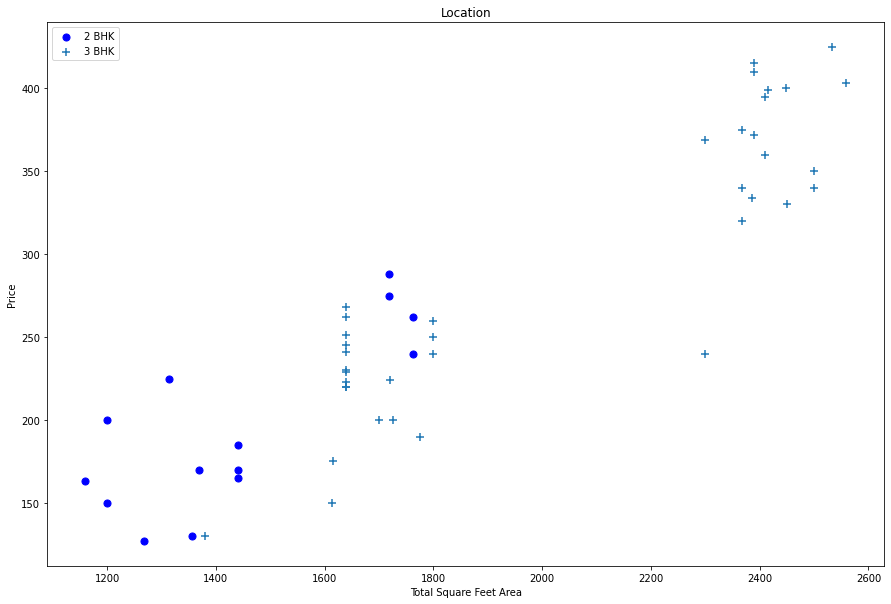

In [31]:
#let check if the price of the house price are difference while the room are same
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk == 2)]
    bhk3 = df[(df.location==location) & (df.bhk == 3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price, color ='blue', label ='2 BHK', s = 50)
    plt.scatter (bhk3.total_sqft,bhk3.price, marker= '+', label = '3 BHK' , s = 50)
    plt.xlabel('Total Square Feet Area')
    plt.ylabel('Price')
    plt.title('Location')
    plt.legend()

    
plot_scatter_chart(df3, 'Rajaji Nagar')